In [1]:
import pandas as pd
import torch
import json
import numpy as np
from torch.utils.data import random_split, DataLoader
from neural_test import train_model, test_model, CustomDataset
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

In [2]:
class DynamicNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(DynamicNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers

        # Create the first layer
        self.layers = [torch.nn.Linear(input_size, hidden_size), torch.nn.ReLU()]

        # Create the hidden layers
        for _ in range(num_hidden_layers):
            self.layers.append(torch.nn.Linear(hidden_size, hidden_size))
            self.layers.append(torch.nn.ReLU())

        # Create the output layer
        self.layers.append(torch.nn.Linear(hidden_size, output_size))

        # Combine all layers
        self.model = torch.nn.Sequential(*self.layers)

    def forward(self, x):
        out = self.model(x)
        if not self.training:
            out = torch.clamp(out, min=1, max=5)
        return out

In [3]:
device = "cpu"
# Load JSON data
with open('topic-sentiment-total.json') as file:
    json_data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame.from_dict(json_data, orient='index')

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert DataFrame to numpy array
data = df.to_numpy()
df.head()

,pos_food,pos_service,pos_location,pos_clean,pos_price,neg_food,neg_service,neg_location,neg_clean,neg_price,rating
0,20,7,2,1,0,7,1,0,0,1,4.3
1,119,37,38,3,11,31,2,0,0,2,4.6
2,228,85,59,4,53,100,42,19,1,23,4.2
3,22,10,2,2,2,4,4,0,1,2,4.2
4,60,32,37,0,7,32,12,8,0,14,4.1


In [4]:
input_dim = 10
hidden_dim = 40
num_hidden_layers = 5
output_dim = 1
learningRate = .01
epochs = 150

lambda1 = 0.0000 # l1 regularization parameter (sum of weights)
lambda2 = 0.0000 # l2 regularization parameter (sum of square of weights)

model = DynamicNN(input_dim, hidden_dim, output_dim, num_hidden_layers).to(device)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size

# Split the dataset
train_data, test_data = random_split(data, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_dataset = CustomDataset(np.array(train_data))
test_dataset = CustomDataset(np.array(test_data))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# train the model on train set
model, mse_history = train_model(model, train_loader, learningRate, epochs, lambda1, lambda2)

# test the model on test set
all_predictions, all_labels, all_inputs = test_model(model, test_loader)

mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_predictions)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.056384749710559845
Root Mean Squared Error: 0.23745472729206085
R-squared: 0.6804748177691028


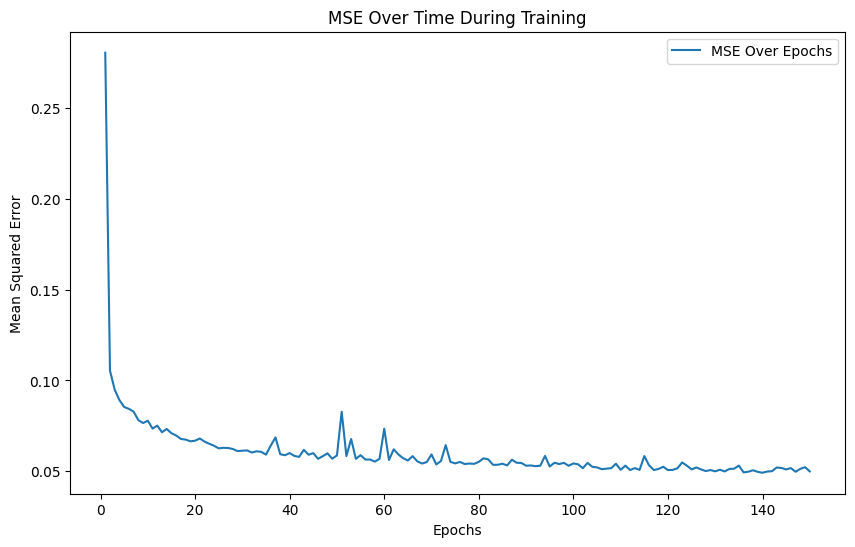

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), mse_history, label='MSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE Over Time During Training')
plt.legend()
plt.show()

In [6]:
k_folds = 5
# Create KFold object
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

models: list[torch.nn.Module] = []

for fold, (train_ids, test_ids) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    train_dataset = CustomDataset(data[train_ids])
    test_dataset = CustomDataset(data[test_ids])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    model = DynamicNN(input_dim, hidden_dim, output_dim, num_hidden_layers).to(device)
    # train the model on train set
    model, mse_history = train_model(model, train_loader, learningRate, epochs, lambda1, lambda2)
    
    # test the model on test set
    all_predictions, all_labels, all_inputs = test_model(model, test_loader)
    
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_labels, all_predictions)
    
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R-squared: {r2}')

    models.append(model)


Fold 1/5
Mean Squared Error: 0.04288764297962189
Root Mean Squared Error: 0.20709331333637238
R-squared: 0.7544739995357203
Fold 2/5
Mean Squared Error: 0.04630505293607712
Root Mean Squared Error: 0.21518608927726746
R-squared: 0.7070064416466428
Fold 3/5
Mean Squared Error: 0.05591773986816406
Root Mean Squared Error: 0.2364693284034729
R-squared: 0.6822319895972355
Fold 4/5
Mean Squared Error: 0.060798149555921555
Root Mean Squared Error: 0.246572807431221
R-squared: 0.6922502972697206
Fold 5/5
Mean Squared Error: 0.06992090493440628
Root Mean Squared Error: 0.2644256055355072
R-squared: 0.6061287404991174


In [7]:
best = models[0] # choose the best model here
# torch.save(best.state_dict(), "nn4_40.pt")

In [8]:
# model = DynamicNN(10, 40, 1, 4).to(device)
# model.load_state_dict(torch.load('nn4_40.pt'))
# torch.cat([x.view(-1) for x in model.parameters()]).tolist()

In [9]:

class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        if not self.training:
            out = torch.clamp(out, min=1, max=5)
        return out

In [10]:
# Load JSON data
with open('restaurant-topic-sentiment.json') as file:
    json_data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame.from_dict(json_data, orient='index')

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert DataFrame to numpy array
data = df.to_numpy()
df.head()

,pos_food,pos_service,pos_location,pos_clean,pos_price,neg_food,neg_service,neg_location,neg_clean,neg_price,rating
0,1.538462,0.538462,0.153846,0.076923,0.000000,0.538462,0.076923,0.000000,0.000000,0.076923,4.3
1,1.525641,0.474359,0.487179,0.038462,0.141026,0.397436,0.025641,0.000000,0.000000,0.025641,4.6
2,0.850746,0.317164,0.220149,0.014925,0.197761,0.373134,0.156716,0.070896,0.003731,0.085821,4.2
3,0.431373,0.196078,0.039216,0.039216,0.039216,0.078431,0.078431,0.000000,0.019608,0.039216,4.2
4,1.000000,0.533333,0.616667,0.000000,0.116667,0.533333,0.200000,0.133333,0.000000,0.233333,4.1


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
model = LinearRegression()

X = np.array(df.drop('rating', axis=1))
y = np.array(df['rating'])

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
prediction = model.predict(X_test)

mse = mean_squared_error(y_test, prediction)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, prediction)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')
model.coef_
model.intercept_

Mean Squared Error: 0.0512677351895066
Root Mean Squared Error: 0.22642379554610995
R-squared: 0.7064990919784704


4.086557333993929

In [12]:
input_dim = 10
output_dim = 1
learningRate = .015
epochs = 100

lambda1 = 0.0005 # l1 regularization parameter (sum of weights)
lambda2 = 0.0005 # l2 regularization parameter (sum of square of weights)

model = linearRegression(input_dim, output_dim).to(device)

k_folds = 5
# Create KFold object
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

models: list[torch.nn.Module] = []

for fold, (train_ids, test_ids) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}/{k_folds}")
    
    train_dataset = CustomDataset(data[train_ids])
    test_dataset = CustomDataset(data[test_ids])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # train the model on train set
    model, mse_history = train_model(model, train_loader, learningRate, epochs, lambda1, lambda2)
    
    # test the model on test set
    all_predictions, all_labels, all_inputs = test_model(model, test_loader)
    
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_labels, all_predictions)
    
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'R-squared: {r2}')

    models.append(model)


Fold 1/5
Mean Squared Error: 0.052503395825624466
Root Mean Squared Error: 0.22913619875907898
R-squared: 0.6994251172259214
Fold 2/5
Mean Squared Error: 0.05128667131066322
Root Mean Squared Error: 0.2264656126499176
R-squared: 0.6754854034349593
Fold 3/5
Mean Squared Error: 0.0627734363079071
Root Mean Squared Error: 0.25054627656936646
R-squared: 0.643272579849389
Fold 4/5
Mean Squared Error: 0.05888679251074791
Root Mean Squared Error: 0.24266600608825684
R-squared: 0.7019252833137355
Fold 5/5
Mean Squared Error: 0.06590893119573593
Root Mean Squared Error: 0.25672733783721924
R-squared: 0.6287286201172206


In [13]:
#best = models[0]
torch.cat([x.view(-1) for x in models[0].parameters()]).tolist()
# torch.save(best.state_dict(), "linear.pt")

[0.42913874983787537,
 0.2747664153575897,
 0.3171444237232208,
 7.394787098746747e-05,
 -0.00027219203184358776,
 -0.8028521537780762,
 -0.8098477721214294,
 -0.2534995675086975,
 -0.5488754510879517,
 -0.1507558971643448,
 4.007617473602295]

In [ ]:
model = linearRegression(10, 1)
model.load_state_dict(torch.load('linear.pt'))
params = torch.cat([x.view(-1) for x in model.parameters()]).tolist()
cols = df.columns.tolist()[:-1]
cols.append("bias")
pd.DataFrame([params], columns=cols)

,pos_food,pos_service,pos_location,pos_clean,pos_price,neg_food,neg_service,neg_location,neg_clean,neg_price,bias
0,0.42659,0.276377,0.310992,-0.007139,-0.000685,-0.801366,-0.818106,-0.185601,-0.611076,-0.168049,4.00566
